In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
import glob
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

#/content/drive/MyDrive/Work/CE/Colab/lab11_dataset

In [2]:
def to1(imgs):
  return ((imgs/255.00)-0.5)*2

def to255(imgs):
  return ((imgs/2)+0.5)*255


In [3]:
def show_49Grid(img_tuple):
  plt.figure()
  f1, axarr1 = plt.subplots(5,5,figsize=(50,50)) 
  index = 0
  for i in range(5):
    for j in range(5):
      axarr1[i][j].imshow(to255(img_tuple)[index].astype(np.uint8))
      index += 1
  plt.plot()

In [4]:
def append_loadedImage(train_dataset,img_size, path):
  filenames = glob.glob(path)
  for i in range(len(filenames)):
    # read image from dataset and resize to train_dataset.shape = img_size using interpolation="bilinear"
    img = load_img(filenames[i], grayscale=False, color_mode='rgb', target_size = 
                  img_size, interpolation="bilinear")
    img = img_to_array(img)
    # rescale train_dataset values [0, 255] -> [-1, 1]
    img = img/255
    new_img = (img-0.5)*2
    train_dataset.append(new_img)
  print(train_dataset[0])
  return train_dataset

11.1 PREPAREIMAGE DATA (REAL, FAKE)

11.1.1 Prepare Real Image

In [5]:
#List all filename in art image path
train_dataset = []
img_size = (32, 32, 3)
append_loadedImage(train_dataset,img_size,"Art_Image_dataset/Art_Bangkok/WaterColor/*.jpg")
append_loadedImage(train_dataset,img_size, "Art_Image_dataset/Abstract_gallery/Abstract_gallery/*.jpg")
append_loadedImage(train_dataset,img_size,"Art_Image_dataset/Abstract_gallery_2/Abstract_gallery_2/*.jpg")
append_loadedImage(train_dataset,img_size,"Art_Image_dataset/CycleGAN/generated_forest_pics_1/*.png")
append_loadedImage(train_dataset,img_size,"Art_Image_dataset/CycleGAN/generated_forest_pics_2/*.png")
# print(len(train_dataset))
train_dataset = np.asarray(train_dataset)
# train_dataset.shape

[[[ 0.06666672  0.09803927 -0.01176471]
  [ 0.05882359  0.09019613 -0.00392157]
  [ 0.05882359  0.09019613  0.0196079 ]
  ...
  [-0.3960784  -0.36470586 -0.41960782]
  [-0.42745095 -0.40392154 -0.46666664]
  [-0.45098037 -0.42745095 -0.5058824 ]]

 [[ 0.082353    0.10588241  0.01176476]
  [ 0.07450986  0.10588241  0.01176476]
  [ 0.07450986  0.10588241  0.04313731]
  ...
  [-0.372549   -0.34117645 -0.40392154]
  [-0.41176468 -0.38039213 -0.44313723]
  [-0.44313723 -0.41176468 -0.4823529 ]]

 [[ 0.10588241  0.13725495  0.03529418]
  [ 0.09803927  0.12941182  0.04313731]
  [ 0.09019613  0.12941182  0.06666672]
  ...
  [-0.3490196  -0.3098039  -0.38039213]
  [-0.38823527 -0.35686272 -0.41176468]
  [-0.41176468 -0.38823527 -0.44313723]]

 ...

 [[ 0.24705887  0.30980396  0.20000005]
  [ 0.2313726   0.30196083  0.21568632]
  [ 0.2313726   0.30196083  0.2313726 ]
  ...
  [-0.06666666  0.01176476 -0.05882353]
  [-0.08235294 -0.01176471 -0.0745098 ]
  [-0.09803921 -0.03529412 -0.09019607]]

 [

In [6]:
# Random Selected images
def generate_real_samples(dataset, n_samples):

  ix = np.random.randint(0, dataset.shape[0], n_samples) # random image index
  # X = dataset[ix] # get image from random pick ix
  X = dataset[ix]
  # generate y = 1 for 'real' class labels
  # y #-> (y.shape = (n_samples,1))
  y = np.ones((n_samples,1))

  return X, y

<Figure size 432x288 with 0 Axes>

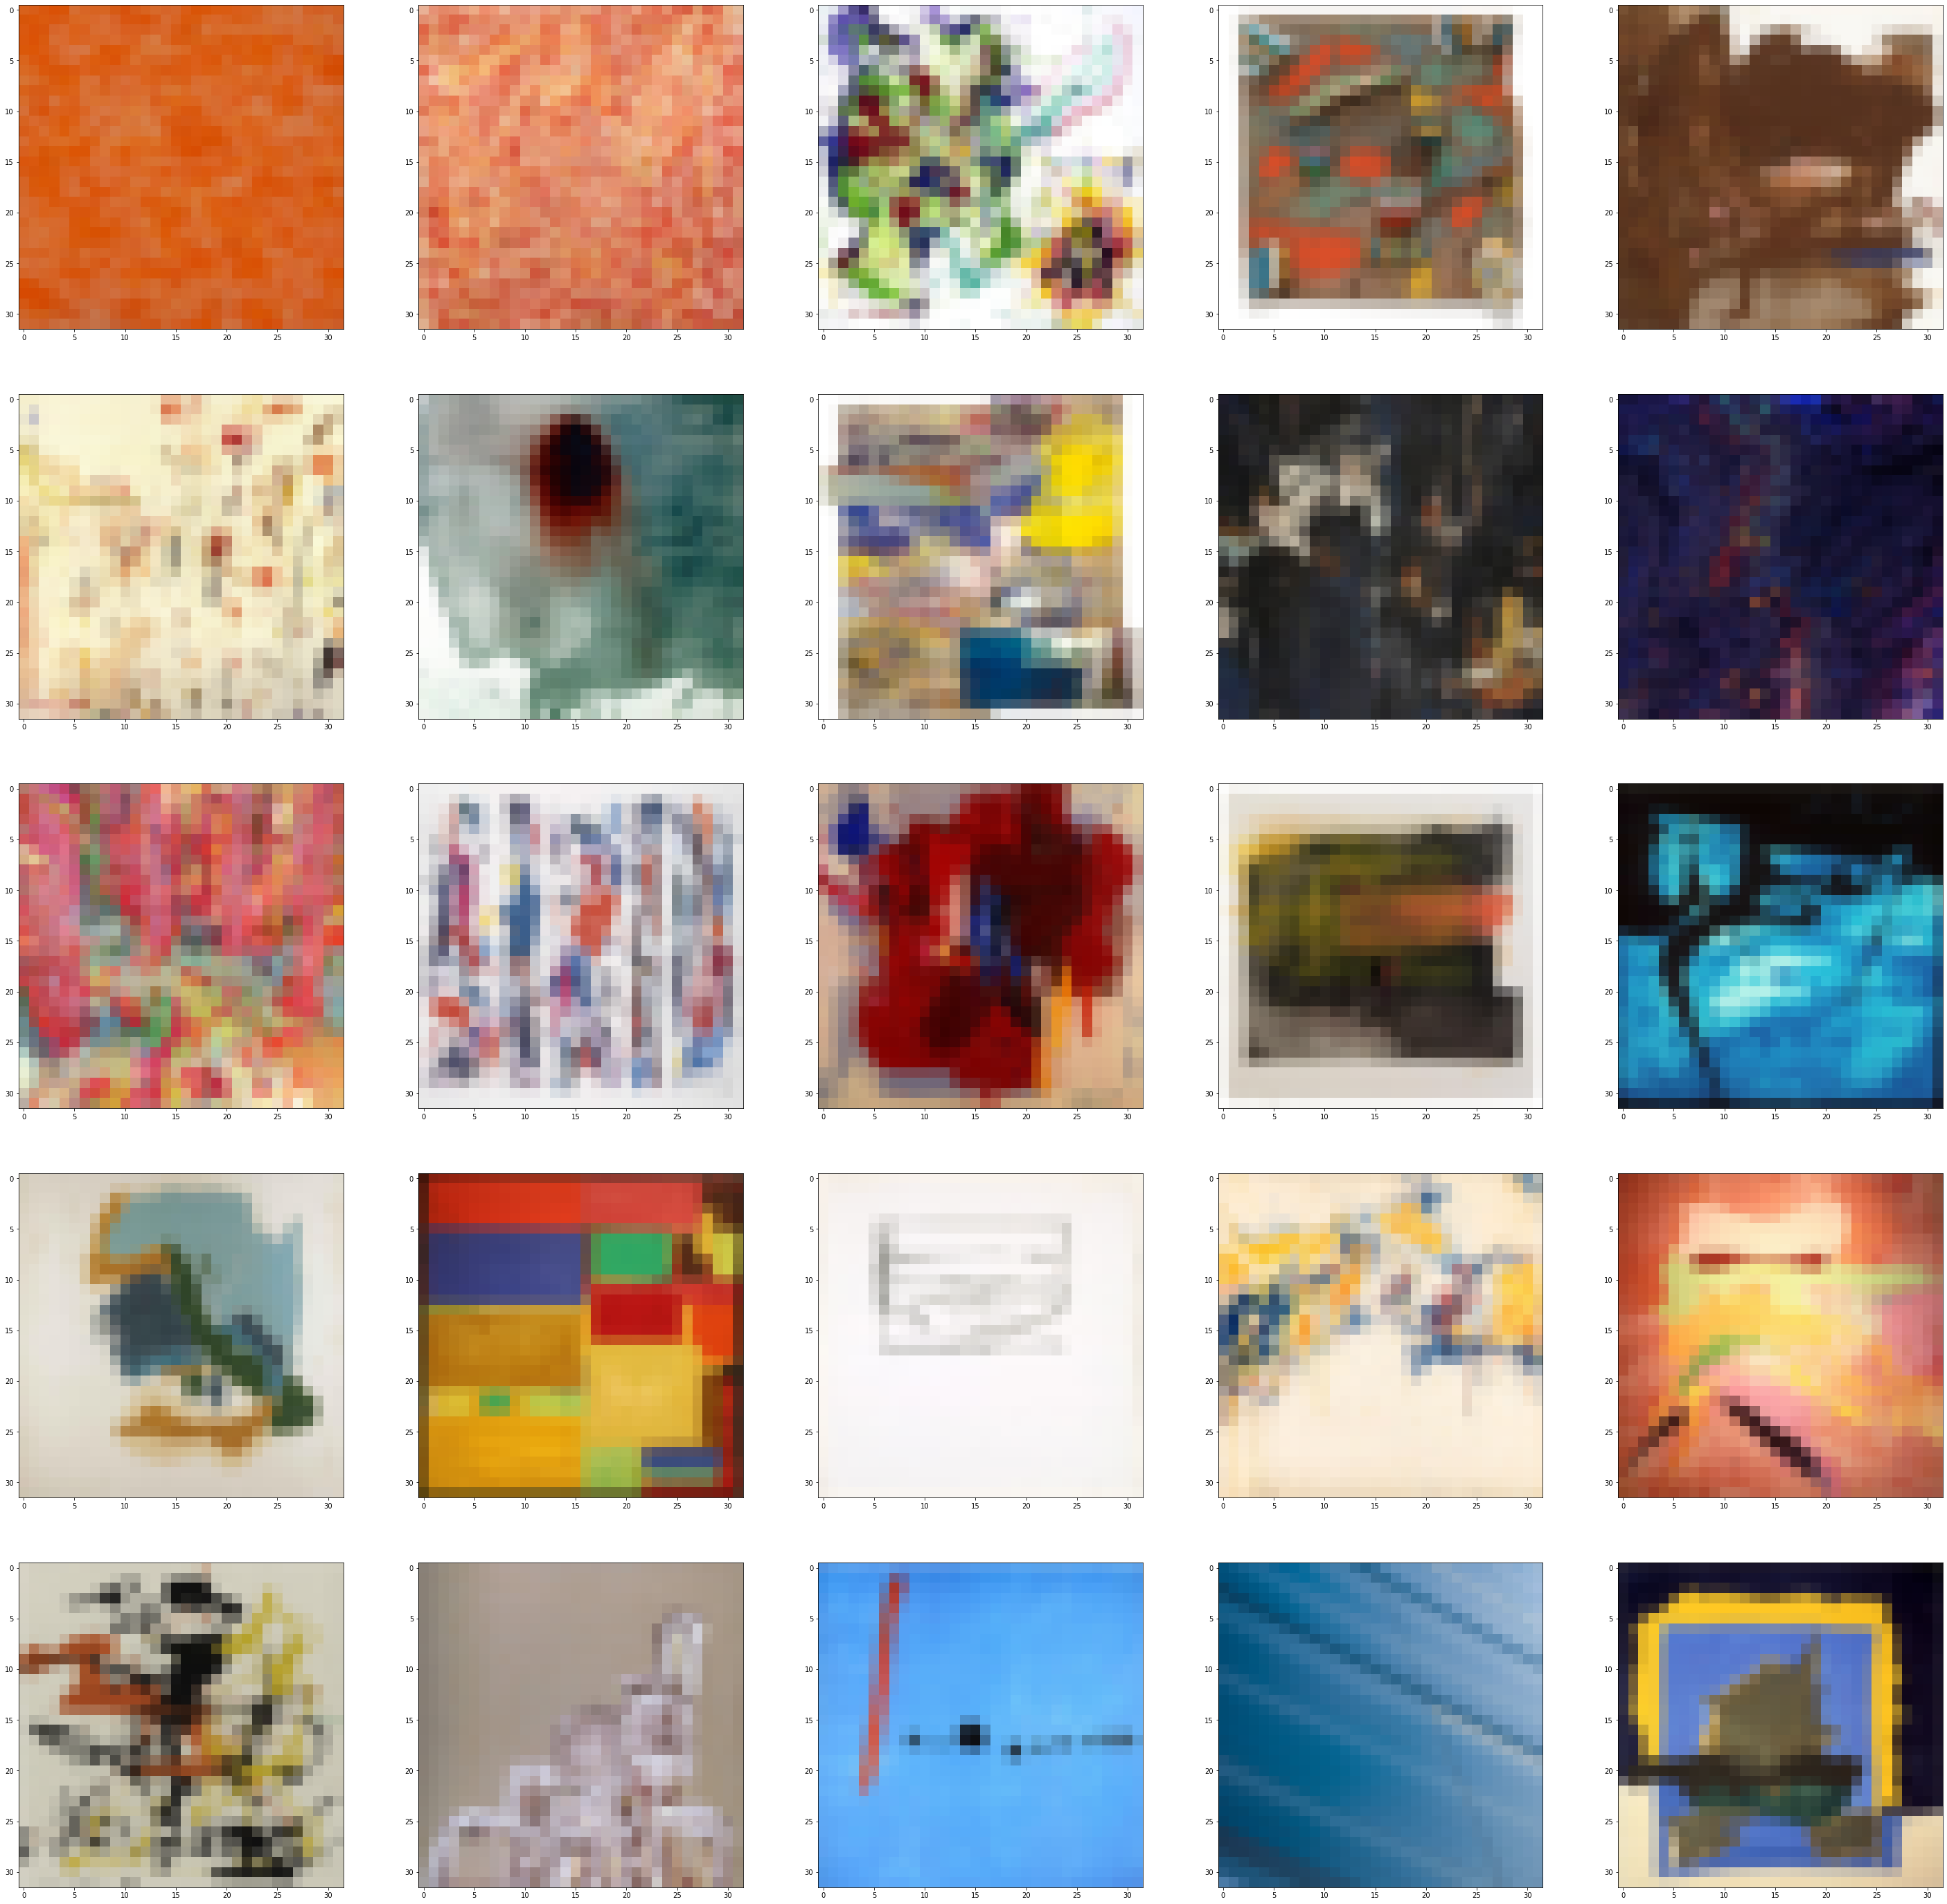

In [7]:
# Display Random Real Images
n_samples = 100

X_real, y_real = generate_real_samples(train_dataset, n_samples)
# print(y_real)
show_49Grid(X_real)

11.1.2 Prepare Fake Image initial for training discriminator(D)

In [8]:
def generate_fake_samples(n_samples, target_size=(32,32,3)):
  h,w,c = target_size
  #-> X.shape = (n_samples * h * w * 3) # random image index
  # rescale X value from [0, 1] to [-1, 1]
  x = (np.random.rand(n_samples*h*w*c)-0.5)*2 
  # reshape X from 1D to 4D 
  # X # X.shape = (n_samples, h, w, c)
  x = np.reshape(x,(n_samples,h,w,c))
  # # generate y = 0 for 'fake' class label
  # y # y.shape = (n_samples,1)
  y = np.zeros((n_samples,1))
  return x, y

<Figure size 432x288 with 0 Axes>

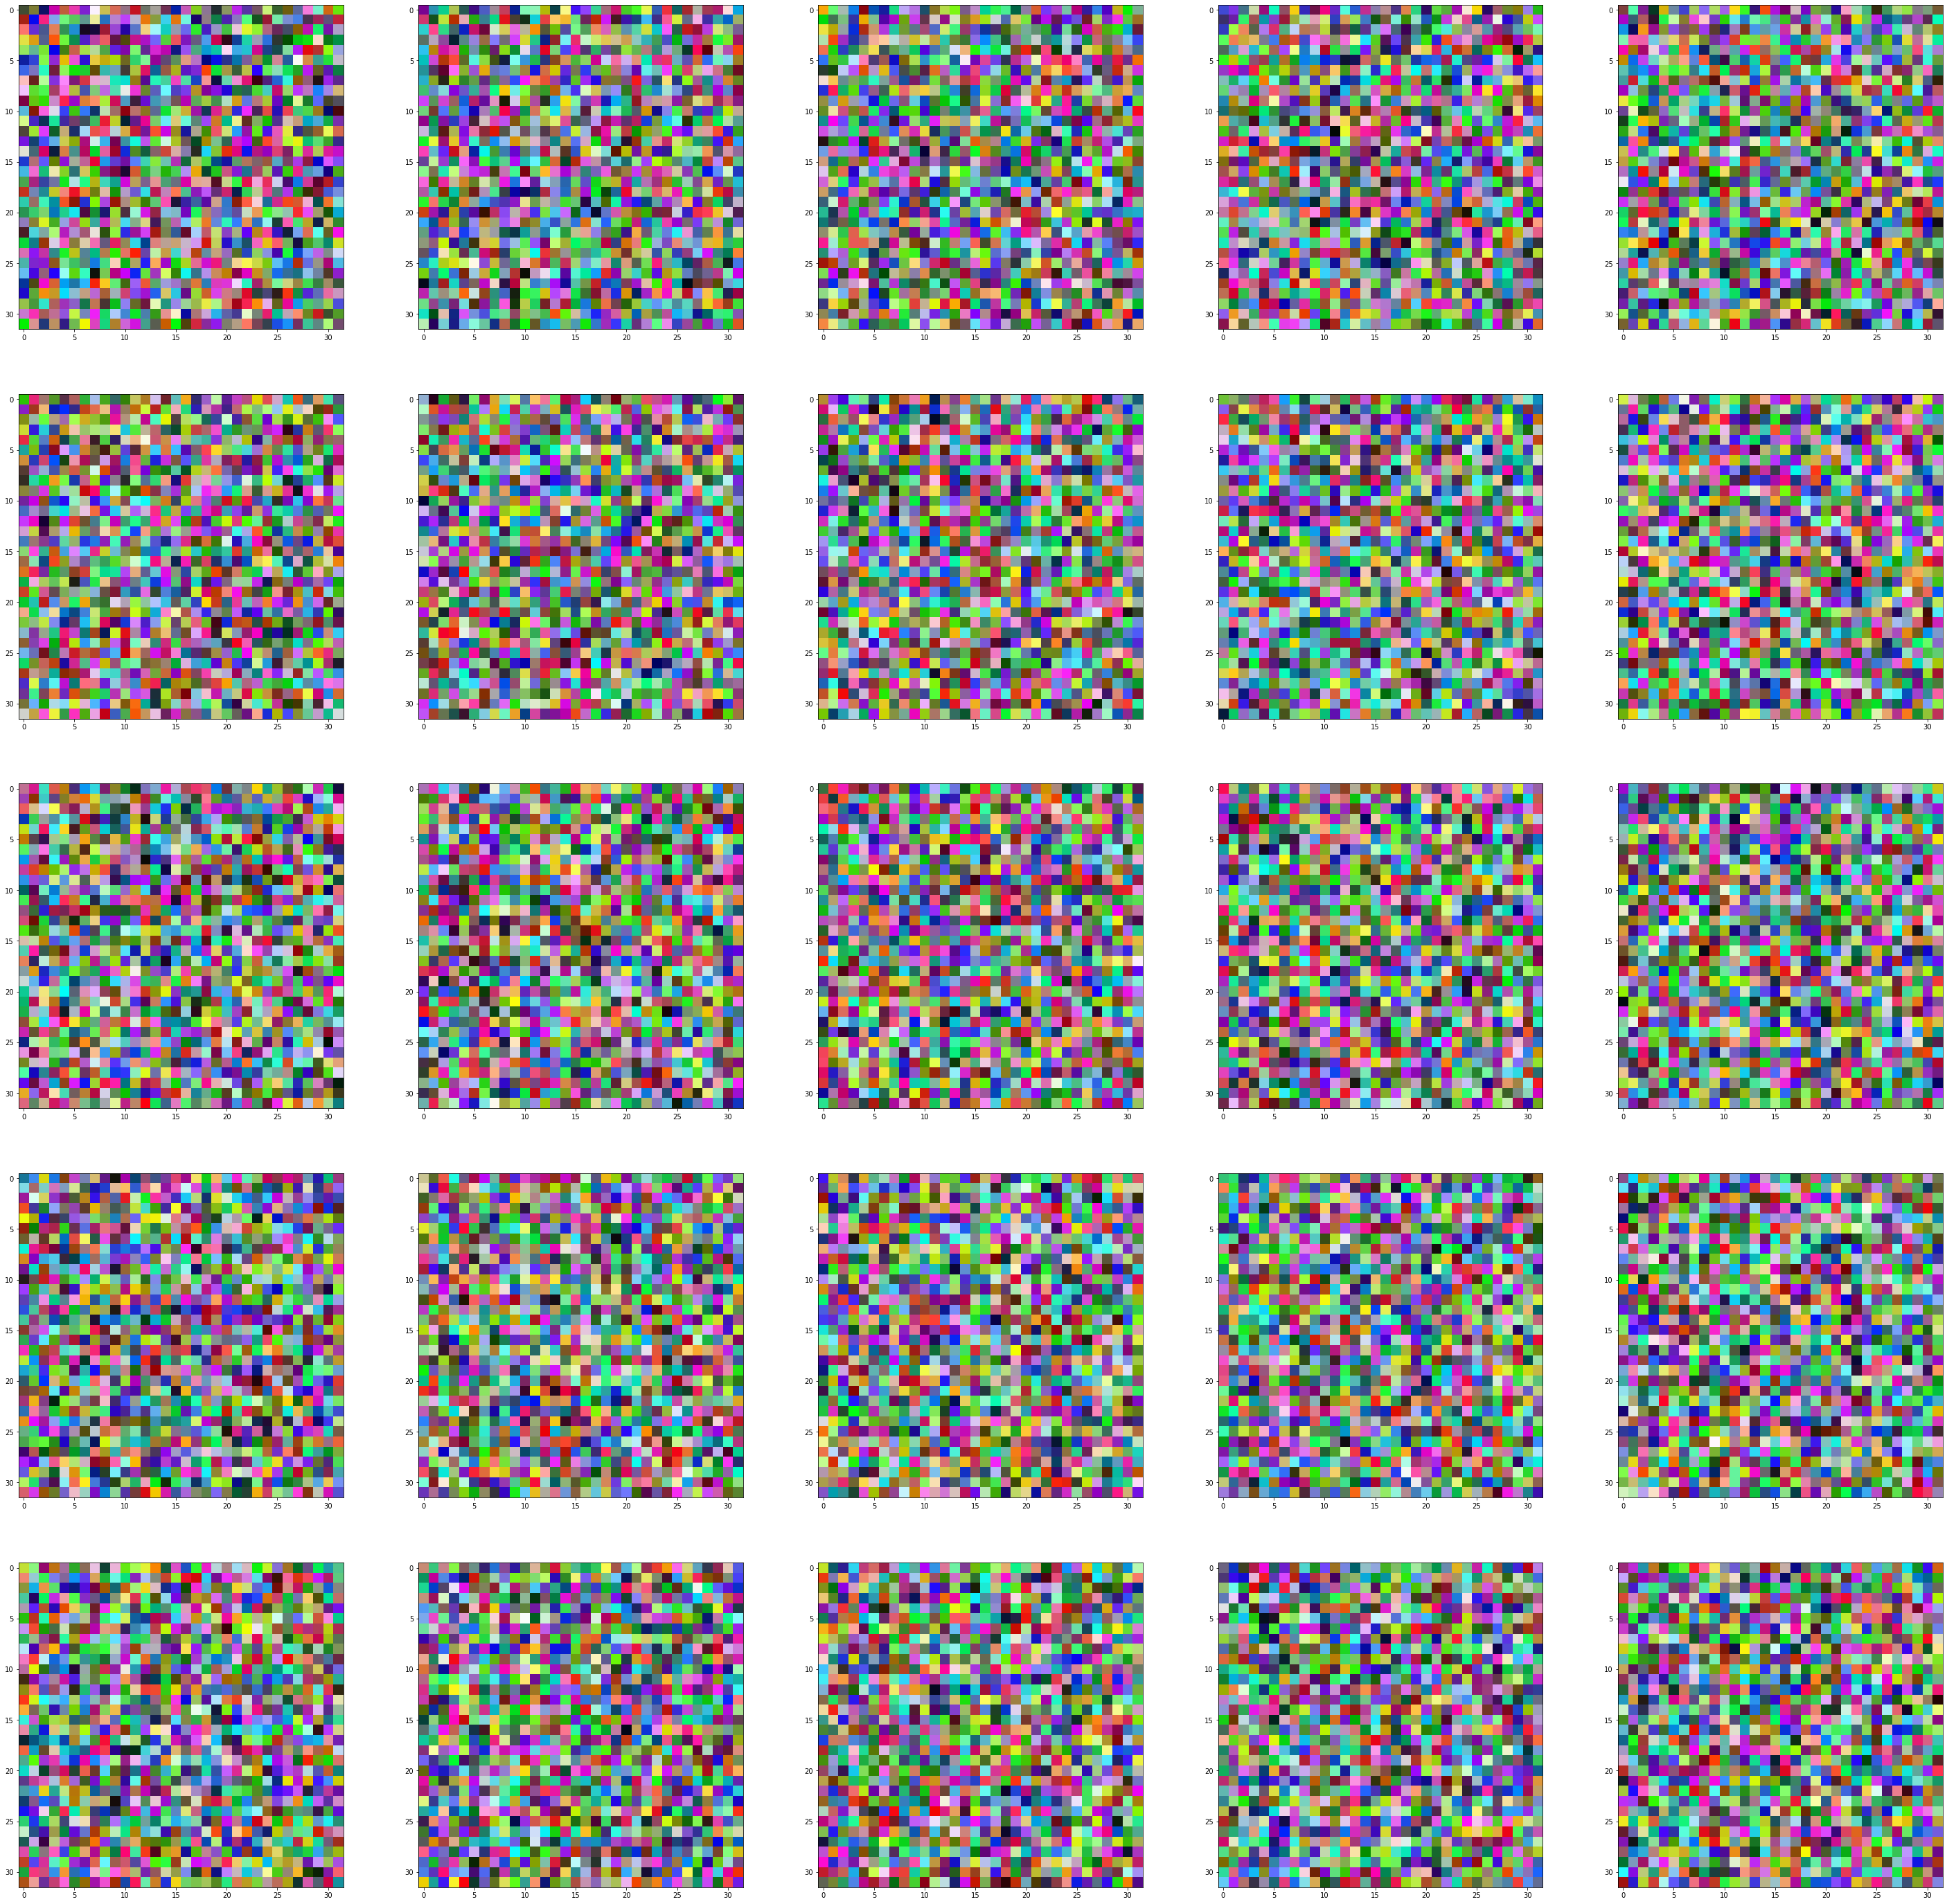

In [9]:
# generate fake image samples
X_fake, y_fake = generate_fake_samples(n_samples, target_size=img_size)
# Display Random Real Images
# rescale to [0, 255] -> dtype = uint8
show_49Grid(X_fake)

11.2 Prepare Discriminator, Generator Model

11.2.1 Create Discriminator Model (D) and Training

In [10]:
# Discriminator Model
def define_discriminator(in_shape=(32,32,3)):
    CNN_L1,CNN_L2,CNN_L3,CNN_L4 = 64,128,128,256
    opt = Adam(lr = 0.0002, beta_1 =0.5)
    Train_loss = "binary_crossentropy"
    model = Sequential()
    # normal
    model.add(Conv2D(CNN_L1, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(CNN_L2, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(CNN_L3, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(CNN_L4, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [11]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32,32,3)):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch, target_size=target_size)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print(real_acc, fake_acc)

In [12]:
#define model
d_model = define_discriminator(img_size)

C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# summarize the model
d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

In [14]:
# Training Discriminator
train_discriminator(d_model, train_dataset, target_size = img_size)

0.453125 0.015625
0.984375 0.15625
0.96875 0.328125
0.890625 0.6875
0.9375 0.890625
0.953125 1.0
0.96875 1.0
0.875 1.0
0.921875 1.0
0.96875 1.0
0.921875 1.0
0.96875 1.0
0.96875 1.0
0.921875 1.0
0.96875 1.0
1.0 1.0
1.0 1.0
0.96875 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96875 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0


11.2.2 Create Generator Model (G)

In [15]:
# define the standalone generator model
def define_generator(latent_dim, discr_out = (256,4,4)):
    model = Sequential()
    # foundation for 4x4 image
    c, w, h = discr_out
    n_nodes = c * w * h
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((w, h, c)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [16]:
# define the generator model
latent_dim = 100
mini_size = [4,4]
g_model = define_generator(latent_dim, discr_out = (256,mini_size[0],mini_size[1]))

In [17]:
# summarize the model
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

11.3 GAN Training and Prediction

11.2.3 Create GAN Model (G,D) and Training

In [18]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [19]:
# generate points in latent space as input for the generator   flag
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = np.random.rand(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

In [20]:
# update generate fake image using generator prediction
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))# y = 0 with shape (n_samples, 1)
    return X, y

In [21]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    Nepoch = 10
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real) # update discriminator model weights
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake) # update discriminator model weights
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))# # create inverted labels for the fake samples y = 0 with shape (n_batch, )
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print(d_loss1, d_loss2, g_loss) # summarize loss on this batch
            # evaluate the model performance, every Nepoch
            if (i+1) % Nepoch == 0:
                summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [22]:
#evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
# prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(acc_real , acc_fake)
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [23]:
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential (Sequential)     (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [24]:
def save_plot(inputs, epoch, n=10):

  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.imshow(to255(inputs)[i].astype(np.uint8))
    plt.axis('off')
  plt.savefig('plot%03d.png' % (epoch + 1))
  # plt.savefig('Activity11/plot%03d.png' % (epoch + 1))
  plt.show()

0.00048318615881726146 1.1682097911834717 0.7161177396774292
0.08272284269332886 0.7068920731544495 1.0191086530685425
0.008852201513946056 0.40243208408355713 1.3638752698898315
0.02003501169383526 0.2819118797779083 1.7155818939208984
0.06284523755311966 0.21844270825386047 1.9835612773895264
0.013911458663642406 0.17742741107940674 2.45556640625
0.01383565180003643 0.1379566788673401 3.21185564994812
0.10345475375652313 0.2969326972961426 4.169859409332275
0.10879085958003998 0.04752274975180626 3.769961357116699
0.07057423889636993 1.4621745347976685 8.234498977661133
4.734692573547363 0.06942577660083771 1.3947274684906006
0.00031023367773741484 1.597982406616211 0.7721955180168152
0.00811532512307167 1.244257926940918 1.482996940612793
0.07939444482326508 0.3314753770828247 3.362875461578369
0.5851439237594604 0.13380789756774902 2.7652173042297363
0.3118022084236145 0.3425368070602417 3.3172926902770996
0.3758474886417389 0.08141012489795685 3.284362554550171
0.5549354553222656 

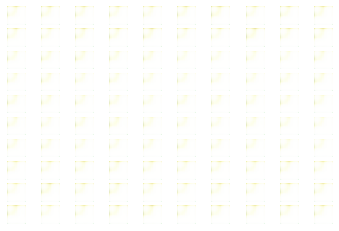

0.052610836923122406 0.0460970476269722 3.640434503555298
0.8866666555404663 1.0


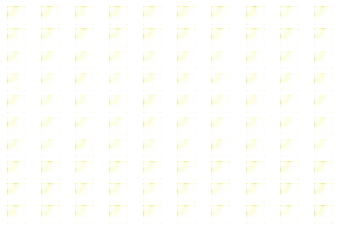

0.17880591750144958 0.04705003276467323 3.402743339538574
0.9266666769981384 1.0


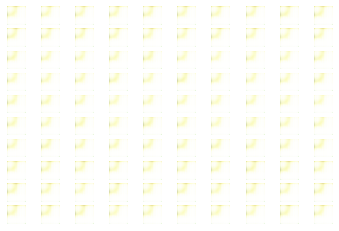

0.03548482432961464 0.049919359385967255 3.391605854034424
0.95333331823349 1.0


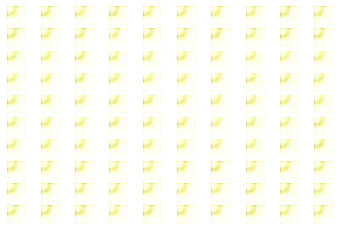

0.1661941558122635 0.13132146000862122 3.0009689331054688
0.9733333587646484 0.0


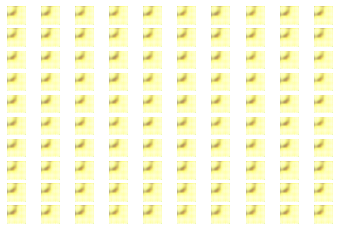

0.18273036181926727 1.8841323852539062 4.283270359039307
0.8266666531562805 1.0


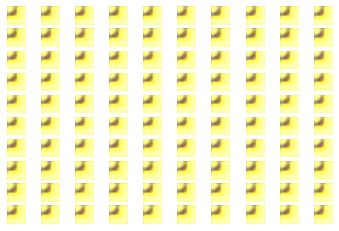

0.7412741184234619 0.055034879595041275 4.024442672729492
0.800000011920929 0.0


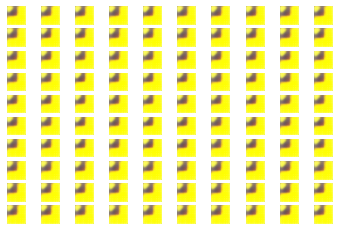

0.47583866119384766 3.9633264541625977 1.756822109222412
0.7266666889190674 0.0


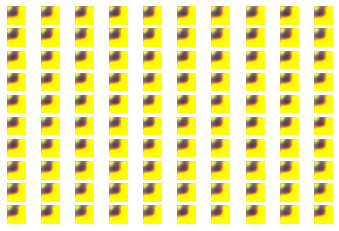

1.040448784828186 0.37828564643859863 3.4135360717773438
0.6666666865348816 0.9933333396911621


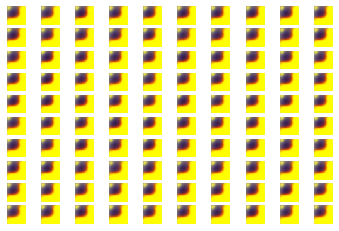

0.5557700395584106 0.21113023161888123 3.938600540161133
0.6666666865348816 0.0


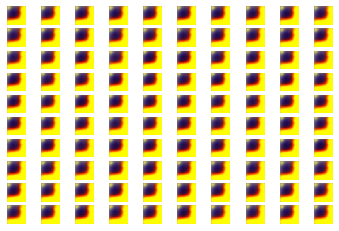

0.8738791942596436 0.6530469655990601 6.349061489105225
0.5933333039283752 1.0


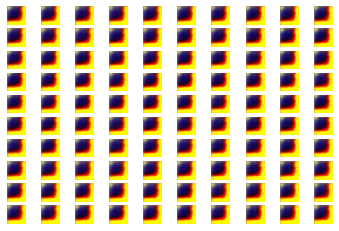

1.7352476119995117 0.03176984190940857 5.9427032470703125
0.6266666650772095 0.0


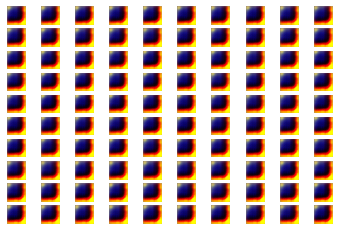

0.6750681400299072 1.6865702867507935 8.927982330322266
0.46666666865348816 1.0


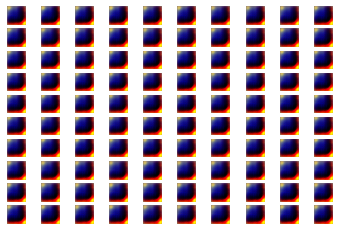

0.97621750831604 0.0011261703912168741 8.457636833190918
0.41333332657814026 1.0


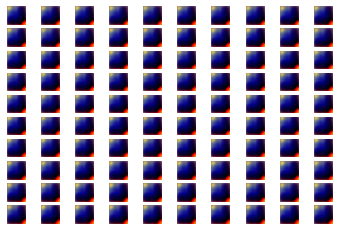

1.2745122909545898 0.01572839729487896 4.463744640350342
0.6066666841506958 1.0


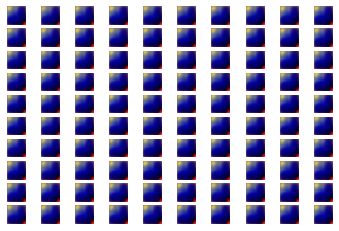

0.7867839336395264 0.9193034172058105 5.449711799621582
0.5066666603088379 1.0


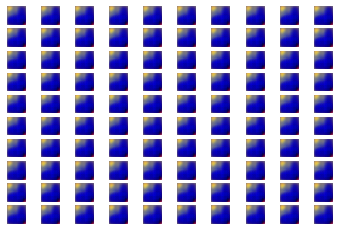

1.0491902828216553 0.04620989039540291 4.094399452209473
0.5533333420753479 1.0


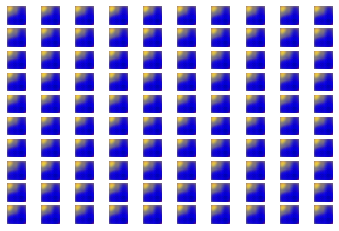

0.8082190155982971 0.39919304847717285 3.2626049518585205
0.7133333086967468 1.0


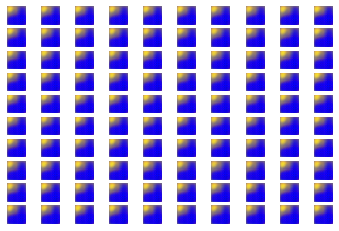

0.49582239985466003 0.13412237167358398 2.907313585281372
0.8066666722297668 1.0


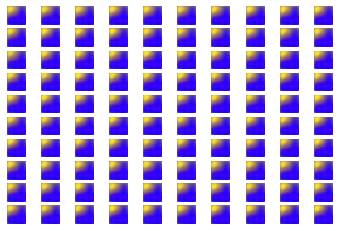

0.3324236273765564 0.35686296224594116 2.429121732711792
0.846666693687439 1.0


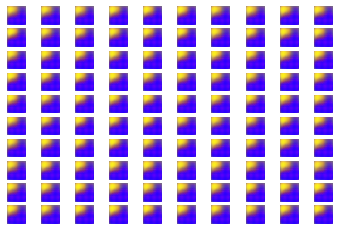

0.34666889905929565 0.3274799883365631 2.7174766063690186
0.800000011920929 1.0


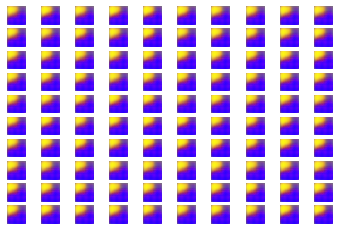

0.38954126834869385 0.22173869609832764 3.0585756301879883
0.6933333277702332 1.0


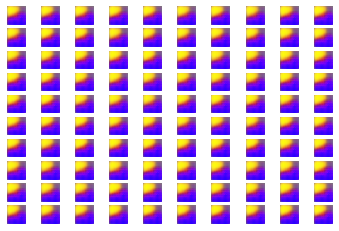

0.3257785439491272 0.32553768157958984 3.6098272800445557
0.7666666507720947 1.0


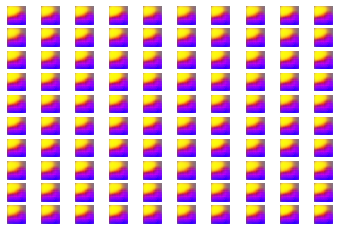

0.4180319309234619 0.3637993335723877 3.637549877166748
0.6800000071525574 1.0


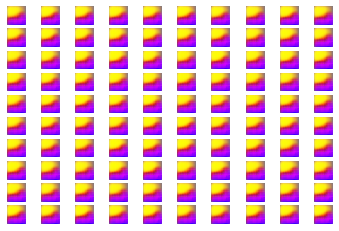

0.6602848768234253 0.22956933081150055 3.4183990955352783
0.6733333468437195 1.0


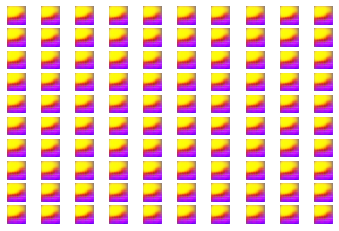

0.5806125402450562 0.22736099362373352 3.036526918411255
0.2367895096540451 0.21634972095489502 3.158914089202881
0.5059624910354614 0.197494238615036 2.8703718185424805
0.46915778517723083 0.5602818727493286 2.1747708320617676
0.45184755325317383 0.9621230363845825 1.0899937152862549
0.4992597699165344 0.6601541042327881 1.1085469722747803
0.31143006682395935 0.3704480528831482 1.5251438617706299
0.4618740677833557 0.2324957549571991 1.7966846227645874
0.3161313831806183 0.19064199924468994 1.9861581325531006
0.21356813609600067 0.14695674180984497 2.173664093017578
0.18124565482139587 0.12309955060482025 2.3731281757354736
0.28125324845314026 0.10871006548404694 2.50776743888855
0.15808933973312378 0.09045775234699249 2.5847840309143066
0.12724044919013977 0.08686716854572296 2.7152199745178223
0.16563428938388824 0.08177922666072845 2.803697347640991
0.11438582837581635 0.07759864628314972 2.8368403911590576
0.09463967382907867 0.08350884914398193 2.79081654548645
0.1020805537700653

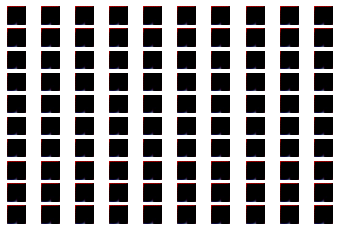

0.03642473742365837 0.020809130743145943 5.109073638916016
0.9866666793823242 1.0


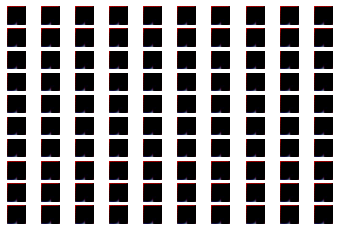

0.022557144984602928 0.009957225061953068 5.160340309143066
0.9866666793823242 1.0


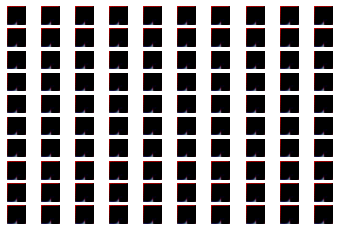

0.0015535971615463495 0.008849546313285828 5.327159404754639
0.9733333587646484 1.0


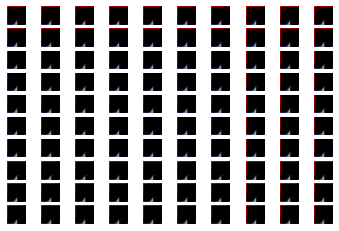

0.0009538483573123813 0.010614406317472458 5.104907989501953
0.9933333396911621 1.0


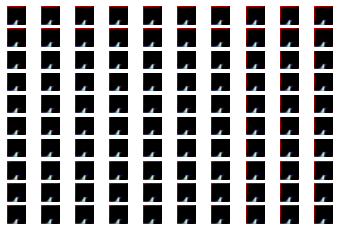

0.04075698181986809 0.053650159388780594 4.205006122589111
0.9800000190734863 1.0


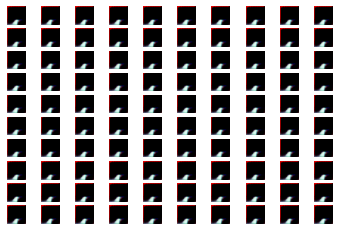

0.007955722510814667 0.11148089915513992 4.7428460121154785
0.9266666769981384 1.0


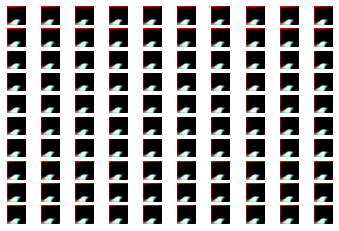

0.22144636511802673 0.1369197815656662 5.283319473266602
0.9200000166893005 1.0


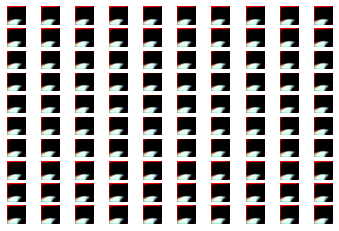

0.09814295172691345 0.03982893005013466 5.801664352416992
0.9333333373069763 1.0


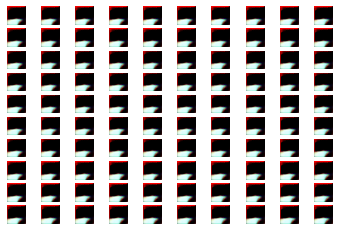

0.6751339435577393 0.24550160765647888 7.233368396759033
0.8666666746139526 1.0


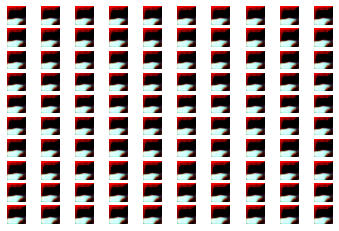

0.16971677541732788 0.011106755584478378 6.301645755767822
0.9066666960716248 0.0


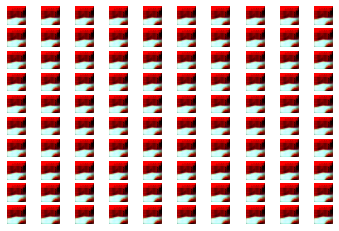

0.6714866161346436 6.004888534545898 13.356199264526367
0.7666666507720947 1.0


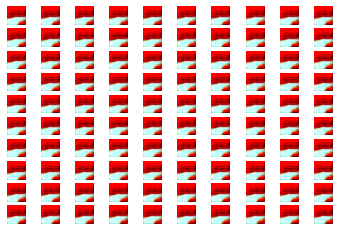

0.9519184231758118 2.0487091489940212e-07 18.37563133239746
0.6733333468437195 1.0


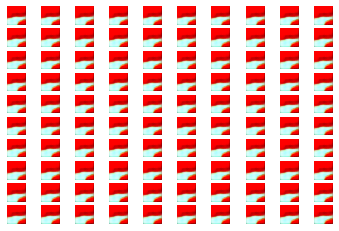

1.0938184261322021 1.6861095275544358e-07 16.449735641479492
0.6666666865348816 1.0


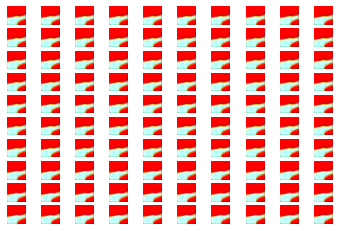

1.1411106586456299 2.4505309283995302e-06 12.94359302520752
0.7133333086967468 1.0


KeyboardInterrupt: 

In [25]:
# train model
train(g_model, d_model, gan_model, train_dataset, latent_dim, n_epochs = 80,n_batch=128)